In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
import numpy as np
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

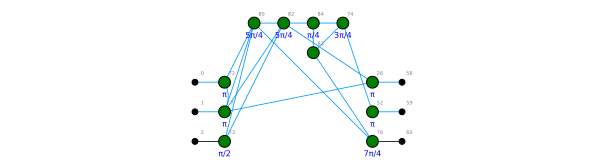

In [3]:
#g = zx.generate.identity(1,2)
#g = zx.quantomatic.edit_graph(g)
g = zx.generate.cliffordT(3,40, p_t=0.2)
zx.simplify.full_reduce(g,quiet=True)
g.normalise()
zx.draw(g,labels=True)

In [22]:
import subprocess
import os
s = subprocess.check_output(["../TOpt", "gsm","../testmatrix.gsm"]).decode()

In [4]:
g2 = g.copy()
zx.simplify.to_rg(g2)
zx.quantomatic.edit_graph(g2)

Opening Quantomatic...
Done


Graph(13 vertices, 21 edges)

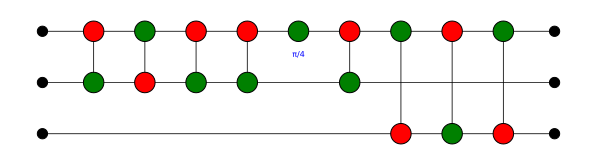

In [220]:
c = zx.Circuit(3)
qubits = c.qubits
c.add_gate("SWAP",1,0)
c.add_gate("ParityPhase", Fraction(1,4),1,0)
c.add_gate("SWAP",0,2)
zx.draw(c)

1.

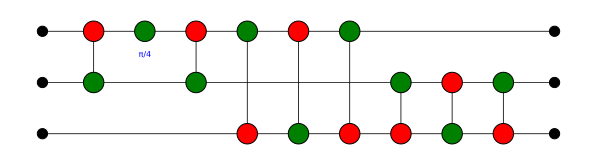

In [228]:
o = zx.optimize.Optimizer(c.to_basic_gates())
circuit, correction = o.parse_circuit(separate_correction=True, quiet=False)
zx.draw(zx.optimize.phase_block_optimize(c.to_basic_gates()))

In [225]:
correction

[SWAP(0,2), SWAP(1,2)]

In [11]:
from pyzx.circuit import SWAP
qubits = 3
permutation = {i:i for i in range(qubits)}
correction = [SWAP(0,1),SWAP(0,2)]
for g in correction:
    if g.name == 'SWAP':
        a = permutation[g.control]
        b = permutation[g.target]
        permutation[g.control] = b
        permutation[g.target] = a
    elif g.name == 'NOT':
        nots.append(g)
    else:
        raise TypeError("Illegal correction {}".format(str(g)))

permutation = {v:k for k,v in permutation.items()}
zx.extract.permutation_as_swaps(permutation)
#permutation

[(0, 2), (1, 2)]

In [227]:
permutation = {i:i for i in range(qubits)}
nots = []
for g in correction:
    if g.name == 'SWAP':
        a = permutation[g.control]
        b = permutation[g.target]
        permutation[g.control] = b
        permutation[g.target] = a
    elif g.name == 'NOT':
        nots.append(g)
    else:
        raise TypeError("Illegal correction {}".format(str(g)))
permutation = {v:k for k,v in permutation.items()}
permutation

{2: 0, 0: 1, 1: 2}

In [198]:
phase_poly, parity_polys = zx.todd.phase_gates_to_poly(c.to_basic_gates().gates, c.qubits)
phase_poly, parity_polys

(x0@x1, [x2, x0, x1])

In [199]:
from pyzx.phasepoly import parity_network
m = phase_poly.to_par_matrix()
newgates = []
parities = []
for col in m.transpose().data:
    #if sum(col) == 1:
    #    newgates.append(T(next(i for i in range(qubits) if col[i])))
    #else:
    parities.append(col)

cnots = parity_network(c.qubits, parities)
parities

[[1, 1, 0]]

In [164]:
cnots

[CNOT(1,0)]

In [200]:
m = zx.Mat2.id(c.qubits)
for cnot in cnots:
    m.row_add(cnot.control, cnot.target)
m

[ 1  1  0 ]
[ 0  1  0 ]
[ 0  0  1 ]

In [166]:
m.to_cnots()

[CNOT(0,1)]

In [201]:
data = []
for p in parity_polys:
    l = [int(i in p.par) for i in range(c.qubits)]
    data.append(l)

m2 = zx.Mat2(data)
m2

[ 0  0  1 ]
[ 1  0  0 ]
[ 0  1  0 ]

In [202]:
target_matrix = zx.Mat2(data) * m.inverse()
target_matrix

[ 0  0  1 ]
[ 1  1  0 ]
[ 0  1  0 ]

In [207]:
perm = zx.linalg.column_optimal_swap(target_matrix.transpose())
swaps = zx.extract.permutation_as_swaps(perm)
m2 = target_matrix.copy()
for a,b in swaps:
    m2.row_swap(a,b)

inv = {v:k for k,v in perm.items()}
m2

[ 1  1  0 ]
[ 0  1  0 ]
[ 0  0  1 ]

In [208]:
trueswaps = zx.extract.permutation_as_swaps(inv)
trueswaps

[(0, 2), (1, 2)]

In [194]:
perm, swaps

({3: 0, 0: 1, 1: 2, 2: 3}, [(0, 3), (1, 3), (2, 3)])

In [205]:
gates = m2.to_cnots(optimize=True)
gates

[CNOT(0,1)]

In [10]:
def generate_parities(targets):
    parities = set()
    for i in range(4):
        a = targets[i]
        parities.add(frozenset([a]))
        for j in range(i+1,4):
            b = targets[j]
            parities.add(frozenset([a,b]))
            for k in range(j+1,4):
                c = targets[k]
                parities.add(frozenset([a,b,c]))
                for l in range(k+1,4):
                    d = targets[l]
                    parities.add(frozenset([a,b,c,d]))
    return parities

s1 = generate_parities([1,2,3,4])
s2 = generate_parities([2,3,4,5])
s3 = generate_parities([1,2,3,5])
#s5 = generate_parities([1,2,3,5])
s1.symmetric_difference(s2).symmetric_difference(s3)#.symmetric_difference(s4))#.symmetric_difference(s5)

{frozenset({1, 2, 3, 4}),
 frozenset({1, 5}),
 frozenset({1, 2, 3, 5}),
 frozenset({1, 2, 4}),
 frozenset({3}),
 frozenset({1, 3, 4}),
 frozenset({4, 5}),
 frozenset({3, 4, 5}),
 frozenset({2, 3, 4, 5}),
 frozenset({1, 3, 5}),
 frozenset({1, 4}),
 frozenset({2}),
 frozenset({1, 2, 5}),
 frozenset({2, 3}),
 frozenset({2, 4, 5})}

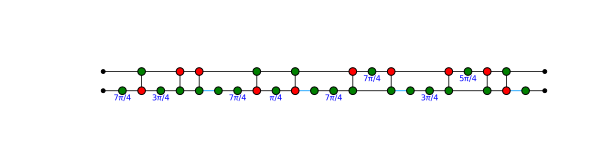

In [5]:
g = zx.generate.circuit_identity_commuting_controls(Fraction(1,4),Fraction(1,4))
zx.simplify.full_reduce(g)
c = zx.extract.streaming_extract(g).to_basic_gates()
c2, blocks = circuit_phase_polynomial_blocks(c,optimize=True)
c3, blocks = circuit_phase_polynomial_blocks(c2,optimize=True)
zx.draw(c3)

[]


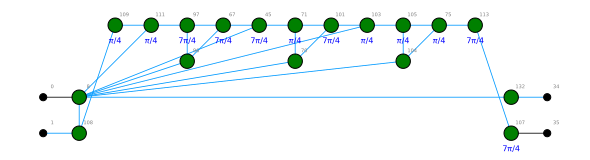

In [39]:
#c = generate_identity(Fraction(5,4),Fraction(7,4))
g = c.to_graph()
zx.simplify.full_reduce(g)
zx.simplify.full_reduce(g)
# zx.simplify.gadgetize(g)
# edges = [(49,55),(55,49),(59,65),(65,59)]
# zx.simplify.pivot_simp(g,matchf=lambda e: e in edges)
# zx.simplify.id_simp(g)
m = zx.rules.match_gadgets_phasepoly(g)
print(m)
#print(alpha, beta, [g.phase(v).numerator for v in g.vertices() if g.phase(v) != 0 and g.phase(v).denominator!=1])
#zx.gadget_simp(g)
# zx.simplify.id_simp(g)
#zx.full_reduce(g)
g.normalise()
zx.draw(g,labels=True)

In [35]:
zx.compare_tensors(g.to_tensor(), zx.generate.identity(2).to_tensor())

True

In [31]:
zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


Graph(18 vertices, 23 edges)

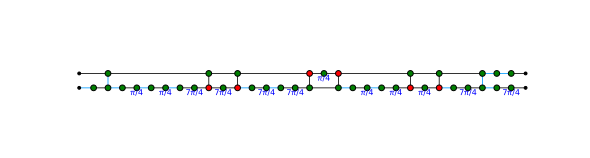

In [36]:
g2 = g.copy()
c2 = zx.extract.streaming_extract(g2)
zx.draw(c2.to_graph())

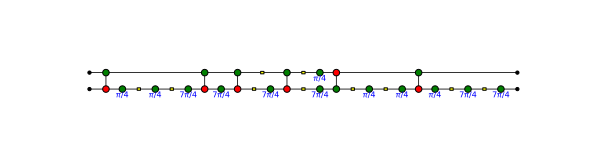

In [37]:
c3, blocks = circuit_phase_polynomial_blocks(c2.to_basic_gates(),optimize=True)
c4, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
g = c4.to_graph()
zx.simplify.id_simp(g,quiet=True)
zx.draw(g,h_edge_draw='box')

In [42]:
zx.compare_tensors(c4,zx.identity(2))

True

In [156]:
g = zx.generate.identity(1,3)
g = zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


In [21]:
a = zx.Circuit(2)
a.add_gate("CZ",0,1)
a.add_gate("CNOT",0,1)
b = zx.Circuit(2)
b.add_gate("S",0)
b.add_gate("S",1)
b.add_gate("CNOT",0,1)
b.add_gate("S",1, adjoint=True)
zx.compare_tensors(a,b)

True

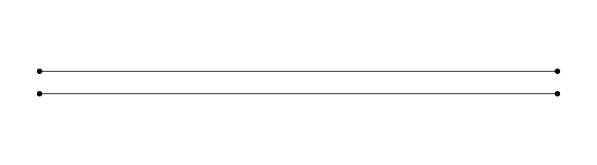

In [49]:
alpha = Fraction(3,5)
beta= Fraction(5,7)

c = zx.Circuit(2)
c.add_gate("XPhase", 1, alpha)
c.add_gate("ZPhase", 1, beta)
c.add_gate("XPhase", 1, alpha)
c.add_gate("NOT", 0)
c.add_gate("NOT", 1)
c.add_gate("CNOT",0,1)
c.add_gate("XPhase", 1, -alpha)
c.add_gate("NOT", 1)
c.add_gate("ZPhase", 1, -beta)
c.add_gate("XPhase", 1, -alpha)
c.add_gate("CNOT",0,1)
c.add_gate("NOT", 0)
c.add_gate("NOT", 1)
c.add_circuit(c)
g = c.to_graph()
zx.full_reduce(g)
zx.draw(g)